# Сборный проект

**Доброго времени суток! Меня зовут Айнур, тут часто спрашивают про «ты»/«вы», я рад любому формату.**

В данном проекте я выстыпаю аналитиком для интернет-магизина «Стримчик». 

**Цель** - с помощью открытых источников данных о продаже игр помочь спланировать магазину рекламные компании путём выявления заномерностей успешности игр на предстоящий год.

Можно выделить следующие **задачи**:
- ознакомление с данными;
- предобработка;
- исследовательский анализ данных;
- составление портрета потребителей по регионам;
- проверка гипотез.

Сами пункты включают в себя подпункты. В данном проекте представлен один датасет.

**P.S.** под строками кода я буду оставлять свои комментарии и делать небольшие выводы в таком формате: **<font color="green">Комментарий студента:<font>** 

In [1]:
!pip install missingno

In [2]:
import pandas as pd
from scipy import stats as st
from math import factorial, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
pd.set_option('display.float_format', '{:.2f}'.format)

**<font color="green">Комментарий студента:<font>** **Установка и импортирование библиотек.**

### Загрузка данных

In [3]:
data = pd.read_csv('/datasets/games.csv')
display(data.head(10))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.00,Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,2006.00,Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**<font color="green">Комментарий студента:<font>**
**Первичное ознакомление с данными.** Всего в датасете 16715 строк, 11 столбцов. Шесть столбцов в числовом формате с плавающей запятой и пять в формате ‘object’. Можно выделить несколько моментов:
- В датасете видны пропуски, особенно их много в последних трёх колонках;
- столбец Year_of_Release в формате float64, а не в формате dt;
- `User_Score` – тип данных object, а не числовой.

### Предобработка данных

In [5]:
data.columns = data.columns.str.lower()

**<font color="green">Комментарий студента:<font>** Преобразуем названия столбцов в нижний регистр

In [6]:
data = data.dropna(subset={'year_of_release'})
data['year_of_release'] = data['year_of_release'].astype('int')

In [7]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

**<font color="green">Комментарий студента:<font>** Переводим `user_score` в числовой формат, в данных встречается аббревиатура **'tbd'** (to be determined = будет определено). 

**Почему** встречается такие данные? Например, когда мы устанавливаем новое приложение на телефон, разработчики через маленькое окошко предлагают перейти в магазин приложения и оценить его. Зачастую пользователи жмут кнопку “не сейчас” или что-то похожее из-за чего появляется информация, что пользователь ещё не сделал свой выбор.

**Предлагаемое решение:**
    
**1.** Так как объём данных с 'tbd' достаточно велик, то удаление этих строк не является рекомендуемым решением. 

    
**2.** Оценки пользователей и оценки критиков являются субъективным мнением, поэтому заполнение медианным/средним значением по некоторому условию (средняя оценка жанра, средняя оценка по платформе и т.д.) не вариант решения задачи, ведь пользователь может поставить плохую оценку игре лишь потому что он не смог пройти первый уровень, а это не отображает реальную среднюю оценку по игре. 

    
**3.** Я приравниваю пропущенные значения и 'tbd', так как по логике они описывают одно и тоже

    
**4.** Пропущенные значения и значения 'tbd' заменить на NaN.

In [8]:
data.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         8983
rating             6678
dtype: int64

**<font color="green">Комментарий студента:<font>** Проверяем на пропуски.

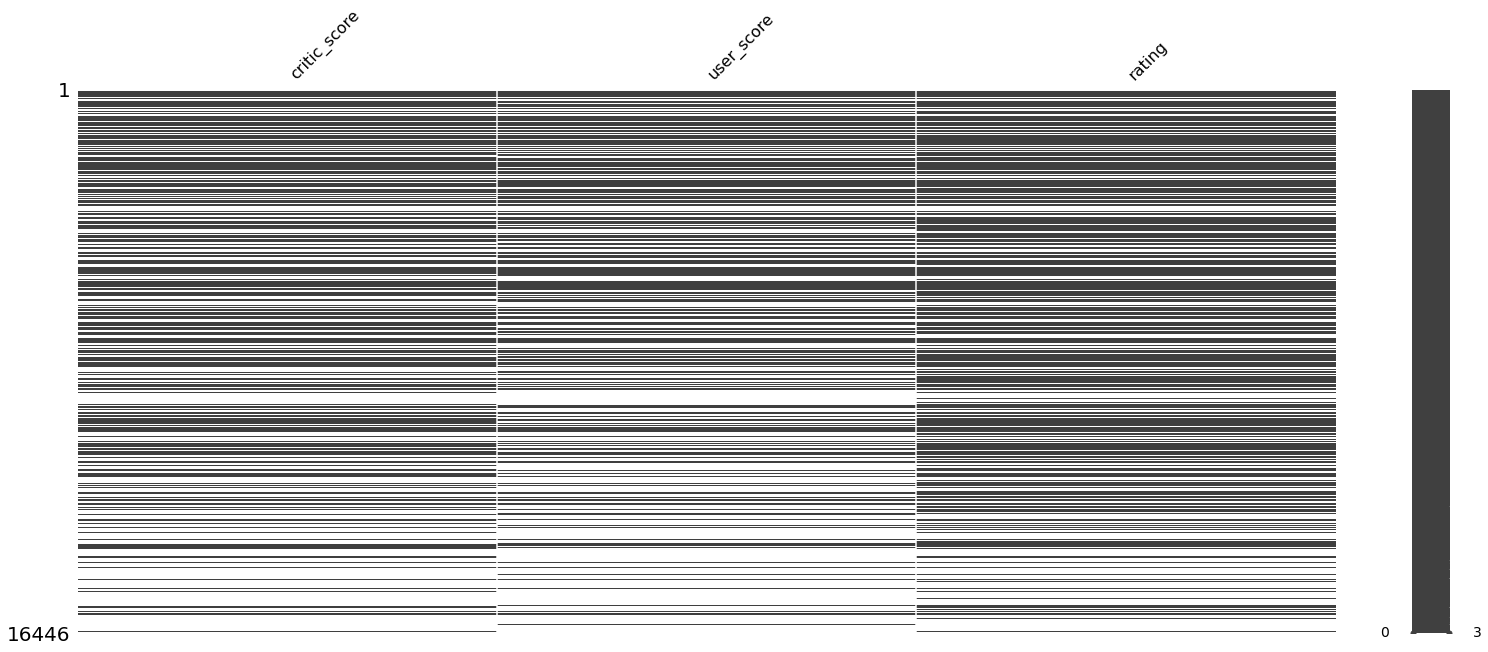

In [9]:
msno.matrix(data[['critic_score', 'user_score', 'rating']])
plt.show()

**<font color="green">Комментарий студента:<font>** Визуализация пропусков. Между пропусками в датасете нет какой-либо связи.

In [10]:
data = data.dropna(subset={'name'})

**<font color="green">Комментарий студента:<font>** Удаление двух пропущенных значений в названии игр. Данные значения восстановить технически сложно.

In [11]:
data['rating'] = data['rating'].fillna('nodata')

**<font color="green">Комментарий студента:<font>** Заполняем пропущенные значения в столбце рейтинга на 'nodata', чтобы можно было оценить сколько игр осталось без рейтинга ESRB.

In [12]:
print(data.duplicated().sum())
print(data['name'].value_counts())
display(data.query('name == "Need for Speed: Most Wanted"'))
data.query('name == "FIFA 14"')

0
Need for Speed: Most Wanted              12
Ratatouille                               9
LEGO Marvel Super Heroes                  9
FIFA 14                                   9
Lego Batman 3: Beyond Gotham              8
                                         ..
Sea Monsters: A Prehistoric Adventure     1
Castlevania: Aria of Sorrow               1
Extreme-G                                 1
Kingdom Hearts 358/2 Days                 1
Professional Farmer 2016                  1
Name: name, Length: 11426, dtype: int64


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005,Racing,2.03,1.79,0.08,0.47,82.00,9.10,T
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.71,1.46,0.06,0.58,NaN,NaN,nodata
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.00,8.50,T
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.00,8.50,T
1998,Need for Speed: Most Wanted,XB,2005,Racing,0.53,0.46,0.00,0.05,83.00,8.80,T
2048,Need for Speed: Most Wanted,PSV,2012,Racing,0.33,0.45,0.01,0.22,NaN,NaN,nodata
3581,Need for Speed: Most Wanted,GC,2005,Racing,0.43,0.11,0.00,0.02,80.00,9.10,T
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.00,8.50,T
6273,Need for Speed: Most Wanted,WiiU,2013,Racing,0.13,0.12,0.00,0.02,NaN,NaN,nodata
6410,Need for Speed: Most Wanted,DS,2005,Racing,0.24,0.01,0.00,0.02,45.00,6.10,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
126,FIFA 14,PS3,2013,Sports,0.78,4.24,0.07,1.37,86.00,4.30,E
271,FIFA 14,X360,2013,Sports,0.92,2.89,0.01,0.40,84.00,4.20,E
469,FIFA 14,PS4,2013,Sports,0.61,1.85,0.11,0.44,87.00,6.30,E
1753,FIFA 14,XOne,2013,Sports,0.41,0.66,0.00,0.09,88.00,5.80,E
4699,FIFA 14,PSV,2013,Sports,0.08,0.23,0.01,0.09,NaN,1.80,E
4809,FIFA 14,PC,2013,Sports,0.01,0.36,0.00,0.03,87.00,4.60,E
4985,FIFA 14,Wii,2013,Sports,0.00,0.36,0.00,0.02,NaN,4.30,E
6871,FIFA 14,3DS,2013,Sports,0.00,0.22,0.00,0.01,NaN,NaN,nodata
7875,FIFA 14,PSP,2013,Sports,0.00,0.15,0.00,0.04,NaN,3.40,E


**<font color="green">Комментарий студента:<font>** Проверка на **явные дубликаты.** Также были рассмотрены повторяющиеся значения в названиях игр. Повторение происходит из-за разнолй даты выхода игр на различные платформы.

In [14]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

**<font color="green">Комментарий студента:<font>** Проверка на неявные дубликаты в столбце `platform`.

In [15]:
print(data['year_of_release'].min())
print(data['year_of_release'].max())

1980
2016


**<font color="green">Комментарий студента:<font>** Рассматриваем в каких промежутках лежат даты выходы игр.

In [16]:
data['critic_score'].describe()

count   7983.00
mean      68.99
std       13.92
min       13.00
25%       60.00
50%       71.00
75%       79.00
max       98.00
Name: critic_score, dtype: float64

**<font color="green">Комментарий студента:<font>** Рассматриваем оценки критиков на аномальные значения.

In [17]:
data['user_score'].describe()

count   7463.00
mean       7.13
std        1.50
min        0.00
25%        6.40
50%        7.50
75%        8.20
max        9.70
Name: user_score, dtype: float64

**<font color="green">Комментарий студента:<font>** Рассматриваем оценки пользователей на аномальные значения.

In [18]:
data['rating'].unique()

array(['E', 'nodata', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

**<font color="green">Комментарий студента:<font>** Проверка на неявные дубликаты в столбце `rating`.

In [19]:
data = data.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first')

In [20]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.reset_index()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,nodata,40.24
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,nodata,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16438,16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,nodata,0.01
16439,16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,nodata,0.01
16440,16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,nodata,0.01
16441,16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,nodata,0.01


**<font color="green">Комментарий студента:<font>** Добавление **нового столбца** с общими продажами во всех регионах, представленных в датафрейме.

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Пропуски:
    
В столбце `name` были удалены два пропуска, так как их восстановление или заполнение каким-либо значением несёт риск ошибиться в игре.
    
В столбце `year_of_release` были удалены более 200 пропусков, более 1% данных. Причина - трудозатратность их восстановления.
    
Основное **предположение** пропусков в двух столбцах - проблема при выгрузке данных.
    
В столбцах `user_score`, `critic_score`, `rating` отсутствует от 40 до 50% данных. Пропуски в столбце `rating` можно обосновать, что рейтинг **ESRB** действует на территории США и Канады. 
    
Пропуски в столбцах оценок можно обосновать таким образом:
- игроки не оставляли свои оценки;
- неполная информация в самих источниках;
- проблема при выгрузке данных.
    
Решение - **оставить** пропуски. Большой объём данных с пропусками, их удаление исказит анализ. Оценки пользователей и оценки критиков являются субъективным мнением, поэтому заполнение медианным/средним значением по некоторому условию (средняя оценка жанра, средняя оценка по платформе и т.д.) не вариант решения задачи, ведь пользователь может поставить плохую оценку игре лишь потому что он не смог пройти первый уровень, а это не отображает реальную среднюю оценку по игре.

**<font color="green">Комментарий студента:<font>** **Промежуточный итог** блока по обработке данных:
    
В **датасете** присутствуют следующие моменты:
    
- большое количество пропусков в столбцах;
    
- неправильные форматы значений;
    
- названия столбцов в смешанном регистре;
    
- некорректные значения в столбце `user_score`.
    
**Что было сделано:**
- в некоторых столбцах были обработаны пропуски, в некоторых удалены строки с пропущенными значениями, некоторые остались без изменений;
- проверены дубликаты;
- числовые значения были проверены на аномальные значения;
- добавлен новый столбец с общими продажами для каждой игры.

### Исследовательский анализ данных

#### Количество игр выпускаемых по годам 

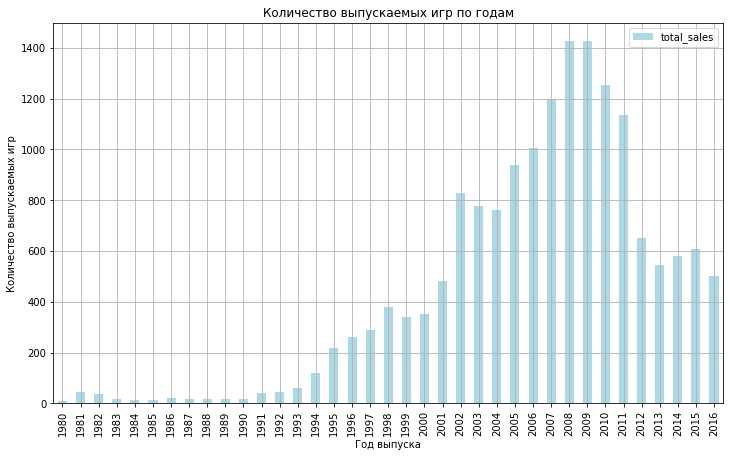

In [22]:
data.pivot_table(index='year_of_release',values='total_sales', aggfunc=('count'))\
.plot.bar(title='Количество выпускаемых игр по годам', figsize=(12,7),\
xlabel='Год выпуска', ylabel='Количество выпускаемых игр', color = "lightblue",grid=True);

**<font color="green">Комментарий студента:<font>** Отчётный период начинается с 1980 года, до 1990 года выпуск игр был на одном уровне, в ’90 начинается небольшой всплеск выпуска игра. Каждые 2-3 года происходит новый скачок в производстве игр. В 2002 году происходит наиболее резкий скачок. Пик в производстве с 2008 до 2011 года, более 4000 игр, после происходит снижение до уровня чуть больше 2000 игра в год.

**В целом все данные важны. Зависит от задачи и условий этой задачи.**

#### Распределение продаж для всех платформ

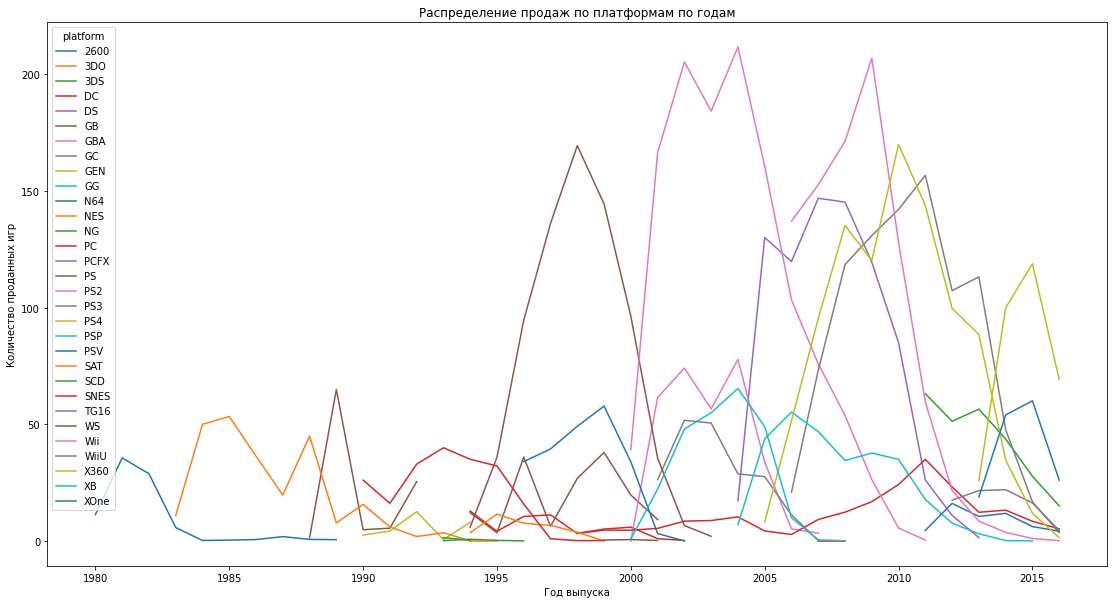

In [23]:
data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc=('sum'))\
.plot(title='Распределение продаж по платформам по годам', figsize=(19,10),\
xlabel='Год выпуска', ylabel='Количество проданных игр');

**<font color="green">Комментарий студента:<font>** 
    
**P.S.** Немного поменял задачи местами

Для начала график распределения продаж для **всех платформ**. 
    
Для большинства платформ средняя длительность **“жизни”** составляет около 10 лет. Это достаточно стандартный срок для игровых платформ. Так как для большинства “железо” внутри них не заменяется, кроме очевидного исключения – **персональный компьютер**. ПК отчёт начинает с 1995 года, но из-за возможности обновления технических параметров, ПК актуален до сих пор.
    
С 1995 года начинается очередной **«всплеск»** в игровой индустрии, в этот раз – выход новых платформ. Можно заметить, что в 2010 году происходит снижение продаж для “старых” платформ в момент активности в производстве игр.

In [24]:
df = data.copy()
df = df.query('year_of_release > 2013')

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Создадим копию датасета и возьмём актуальный период с 2014 года.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           1689 non-null   object 
 11  total_sales      1689 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 171.5+ KB


In [26]:
df.duplicated().sum()

0

#### Распределение продаж по наиболее популярным платформам по годам за актуальный период

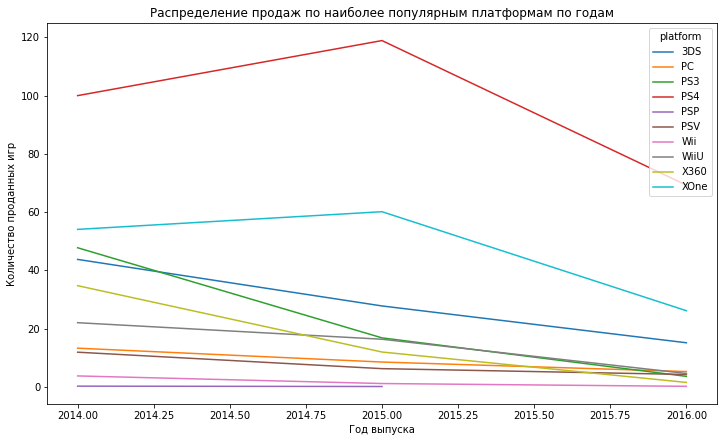

In [27]:
df.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc=('sum'))\
.plot(title='Распределение продаж по наиболее популярным платформам по годам', figsize=(12,7),\
xlabel='Год выпуска', ylabel='Количество проданных игр');

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Построим график распределния продаж с 2010 года.
    
**Лидируют:**

Начиная с 2014 года лидерами являются XOne, PS4

**Падают:**
    
Все представленные платформы, кроме двух(XOne, PS4). Можно связать с устарением возможностей платформ. Они попросту не могут “потянуть” новые игры.
    
**Растут:**
    
PS4, XOne.

Можно сделать вывод, что с 2010 года появляются две платформы, которые занимают бОльшую часть рынка, с 2014 занимают лидирующие позиции, сильно опережая конкурентов.
    
**Две потенциально прибыльные платформы**: PS4 и XOne, линейка платформ от Sony и Microsoft (на данный момент они тоже являются лидерами)
    
**Учтём, что данные за 2016 могут быть неполными, поэтому на графике характерны снижения показателей по всем платформам**

In [28]:
dataw = df.pivot_table(index=['platform'], values=['total_sales'], aggfunc=['sum'])
dataw.sort_values(by=[('sum', 'total_sales')], ascending=False)

,sum
,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40


**<font color="green">Комментарий студента:<font>** Убедимся в лидерах продаж с помощью чисел.

#### График «ящик с усами» по глобальным продажам игр в разбивке по платформам

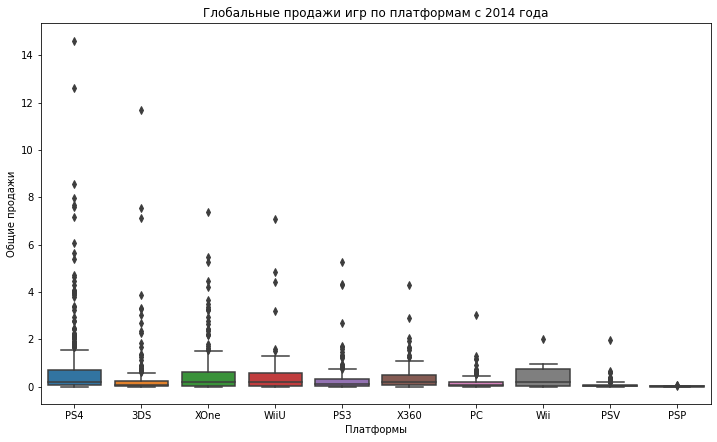

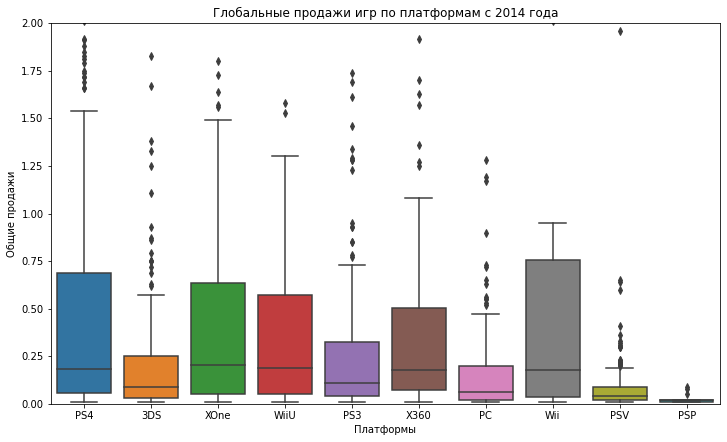

In [29]:
plt.figure(figsize=(12,7));
sns.boxplot(x='platform', y='total_sales', data=df).set (title='Глобальные продажи игр по платформам c 2014 года');
plt.xlabel('Платформы');
plt.ylabel('Общие продажи');

plt.figure(figsize=(12,7));
sns.boxplot(x='platform', y='total_sales', data=df).set (title='Глобальные продажи игр по платформам c 2014 года');
plt.ylim(0,2) 
plt.xlabel('Платформы');
plt.ylabel('Общие продажи');

<div class="alert alert-info"> <b>Комментарий студента №2:</b>
    
В датасете присутствуют значения продаж по платформам, которые выходят за пределы **третьего квартиля + 1.5 межквартильного размаха.** Стоит предположить, что данные значения связаны с популярностью определенных игр.
    
Значения меньше **первого квартиля - 1.5 межквартильного размаха** - отсутсвуют.

In [30]:
display(df.query('platform == "XOne" and total_sales > 5'))
display(df.query('platform == "PS4" and total_sales > 12'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,nodata,7.39
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97.00,7.90,M,5.47
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81.00,5.40,M,5.26


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,nodata,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.00,8.30,M,12.62


<div class="alert alert-info"> <b>Комментарий студента №2:</b> Проверим три наиболее отдаленных значения для одной платформы. Достаточно известные игры, всё ок.
    
**Результатом исследования** является обнаружения значений, которые выходят за пределы **«ящика с усами»**, но выбрав интересующие нас платформы приходим к выводу, что данные **«аномалии»** - нормальное явление. На рынке игр существуют свои лидеры.

#### Анализ взаимосвязей между оценками и продажами

**<font color="green">Комментарий студента:<font>** Платформа для анализа – **PS4**

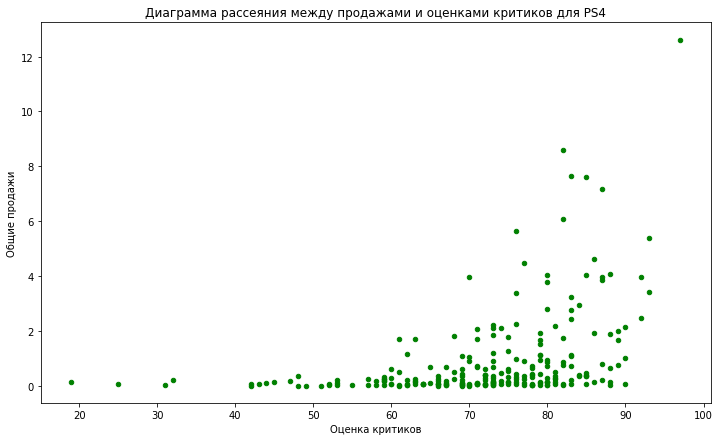

In [31]:
PS4 = df.query('platform == "PS4"');
PS4.sort_values('critic_score').plot(x='critic_score', y='total_sales', kind='scatter', figsize=(12,7), color='green')\
.set (title='Диаграмма рассеяния между продажами и оценками критиков для PS4');
plt.xlabel('Оценка критиков');
plt.ylabel('Общие продажи');

**<font color="green">Комментарий студента:<font>** Строим **диаграмму рассеяния** (**оценки критиков** и общими продажами). Визуально взаимосвязи нет. Рассчитаем с помощью метода **corr()**

In [32]:
PS4['total_sales'].corr(PS4['critic_score'])

0.40266141068104083

**<font color="green">Комментарий студента:<font>** Взаимосвязь **присутствует**, но не сказать, что она является **существенной**.

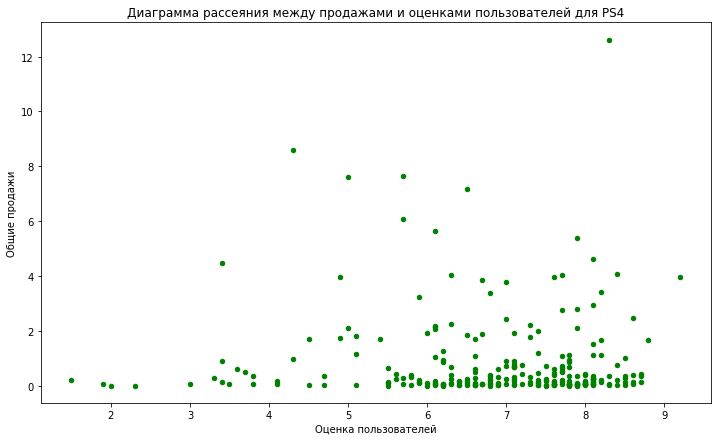

In [33]:
PS4.sort_values('critic_score').plot(x='user_score', y='total_sales', kind='scatter', figsize=(12,7), color='green')\
.set (title='Диаграмма рассеяния между продажами и оценками пользователей для PS4');
plt.xlabel('Оценка пользователей');
plt.ylabel('Общие продажи');

**<font color="green">Комментарий студента:<font>** Строим **диаграмму рассеяния** (**оценки пользователей** и общими продажами). Рассмотрим с помощью метода **corr()**:

In [34]:
PS4['total_sales'].corr(PS4['user_score'])

-0.040131589472697356

**<font color="green">Комментарий студента:<font>** Коэффициент корреляции **Пирсона**  близок к нулю, взаимосвязи практически нет.
    
Обосновать данные показатели можно тем, что оценка – **субъективный** показатель, который может не нести реальное отражение действительности.

In [35]:
XOne = df.query('platform == "XOne"')
PS3 = df.query('platform == "PS3"')
X360 = df.query('platform == "X360"')
DS = df.query('platform == "3DS"')
PC = df.query('platform == "PC"')

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Рассмотрим другие платформы:
    
Каждый график и вывод по корреляции будет идти в следующем порядке:
    **XOne, PS3, X360, DS**
    
**P.S** Вопрос к ревьюеру.
    Как в цикле показать названия платформ в наименовании графика и название платформ в цикле для корреляции при выводе?

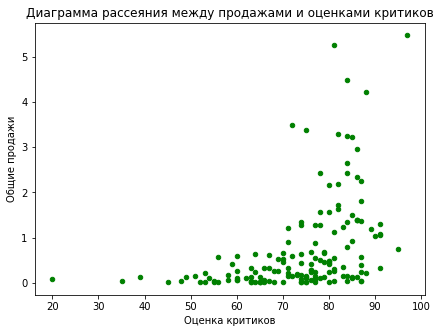

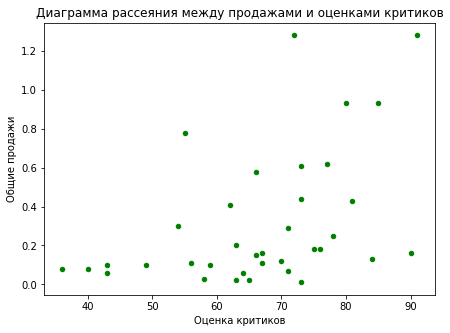

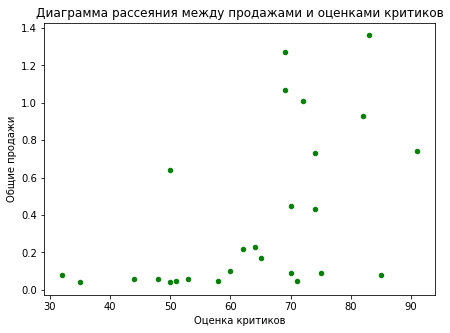

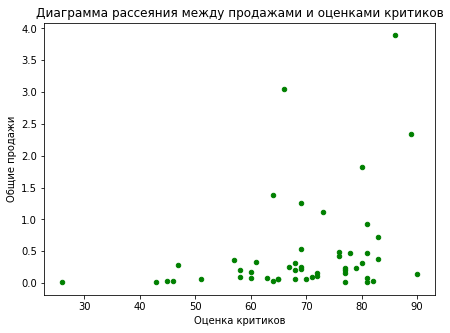

In [37]:
qwe = [XOne, PS3, X360, DS]
for q in qwe:
    q.sort_values('critic_score').plot(x='critic_score', y='total_sales', kind='scatter', figsize=(7,5), color='green')\
.set (title='Диаграмма рассеяния между продажами и оценками критиков');
    plt.xlabel('Оценка критиков');
    plt.ylabel('Общие продажи');    

In [38]:
for asd in qwe:
    a = asd['total_sales'].corr(asd['critic_score'])
    print('Корреляция между продажами и оценками критиков составляет:', a)

Корреляция между продажами и оценками критиков составляет: 0.42867694370333226
Корреляция между продажами и оценками критиков составляет: 0.44657460493190704
Корреляция между продажами и оценками критиков составляет: 0.5257228356581523
Корреляция между продажами и оценками критиков составляет: 0.31411749286905105


<div class="alert alert-info"> <b>Комментарий студента №2:</b>
    
Визуально можно соотнести, что большинство игр с оценками от 60 до 90 имеют продажи менее 2 млн копий. Для **PS3** и **X360** график рассеяния имеют некую безобразную структуру, но также стоит отметить небольшое количество значений для этих платформ.
    
**Коэффициент корреляции Пирсона** показывает о средней связи между оценками критиков и продажами. Платформы с малым количеством значений показывают коэффициент чуть больше, чем у платформ с бОльшим количеством значений.
    
Что касается выбранной платформой **PS4** и другими. Результаты анализа схожи. Полученные суждения о оценки критиков достаточно справедливы и для других выбранных платформ.

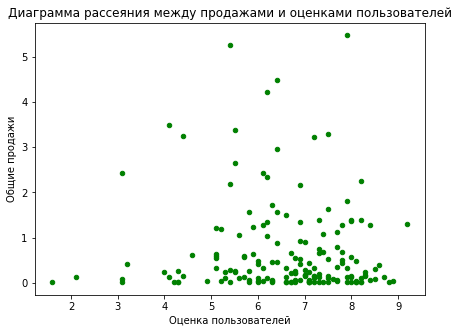

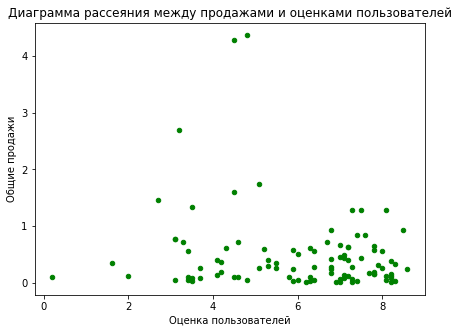

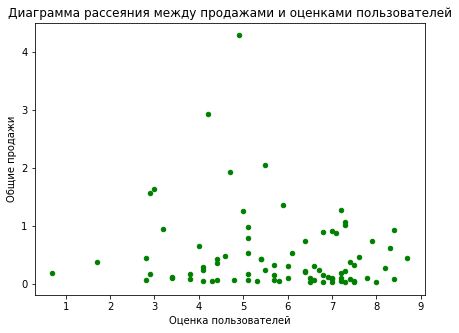

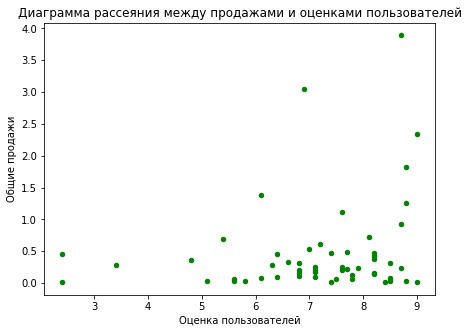

In [39]:
for w in qwe:
    w.sort_values('user_score').plot(x='user_score', y='total_sales', kind='scatter', figsize=(7,5), color='green')\
.set (title='Диаграмма рассеяния между продажами и оценками пользователей');
    plt.xlabel('Оценка пользователей');
    plt.ylabel('Общие продажи');    

In [40]:
for zxc in qwe:
    b = zxc['total_sales'].corr(zxc['user_score'])
    print('Корреляция между продажами и оценками пользователей составляет:', b)

Корреляция между продажами и оценками пользователей составляет: -0.0703839280647581
Корреляция между продажами и оценками пользователей составляет: -0.16676141347662116
Корреляция между продажами и оценками пользователей составляет: -0.138444570945665
Корреляция между продажами и оценками пользователей составляет: 0.2151932718527028


<div class="alert alert-info"> <b>Комментарий студента №2:</b> Визуально трудно установить взаимосвязь между оценками пользователей и продажами, подтверждение этому и результаты расчёта коэффициента Пирсона. Значения разбросаны в хаотичном порядке.
    
Сравнение между **PS4** и другими платформами. Ранне озвучанные суждения справедливы и для других платформ.

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Промежуточный вывод для платформ в сравнении:
    
В **большинстве** случаев общие продажи игр **не имеют** взаимосвязи с оценками **пользователей**. Оценки **критиков** могут нести некую **полезную** информацию, но рассчитывать **только на неё не стоит**.
    
Зачастую магазину нужно будет игнорировать оценки пользователей. Но стоит учитывать оценки критиков.

#### Распределение продаж по платформам по годам

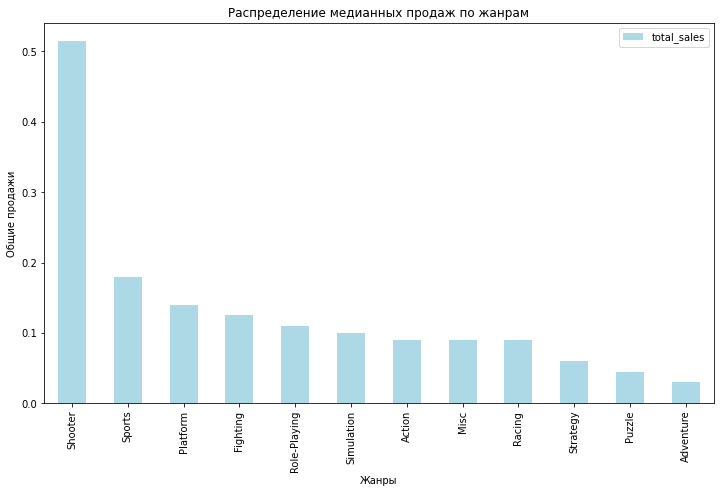

In [41]:
df.pivot_table(index='genre', values='total_sales', aggfunc=('median')).sort_values(by=['total_sales'], ascending=False)\
.plot(kind='bar', title='Распределение медианных продаж по жанрам', figsize=(12,7),color = "lightblue");
plt.xlabel('Жанры');
plt.ylabel('Общие продажи');

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Лидером среди медианных показателей является с большим преимуществом жанр **Shooter.** Далее с плавным распределением показатели продаж переходят к спортивным симуляторам, платформерам, файтингам и т.д.
    
Магазину стоит сделать акцент на **шутеры**, наименее привлекательны для продажи приключенческий жанр, паззлы и стратегии.

**<font color="green">Промежуточный вывод №2:<font>** 
    
- Массовое производство игр с 1990 года, пик в 2010;

- Средний срок "жизни" платформы - 10 лет;
- Актуальный период -- начиная с 2014 года;
- Наиболее привлекательные платформы - PS4/XOne;
- Слабая связь между оценками и продажами игр;
- Shooter самый привлекательный жанр.

### Портеры пользователей

#### Распределение продаж по платформам в разных регионах

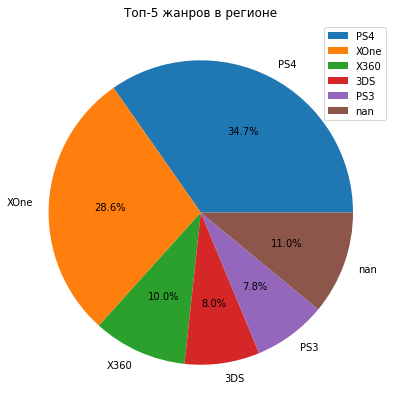

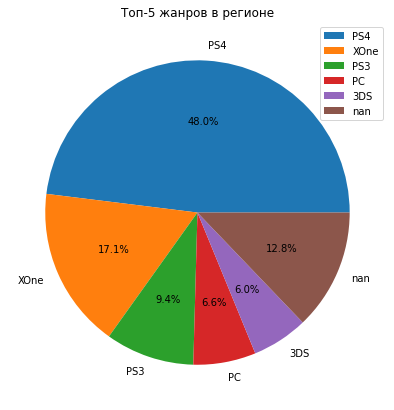

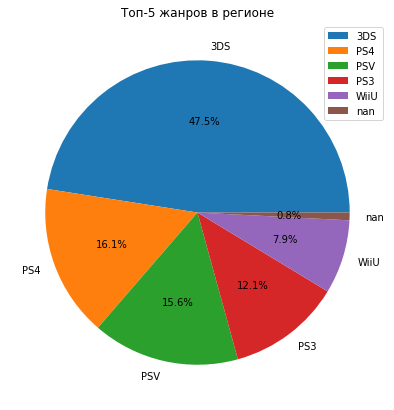

In [42]:
po = ['na_sales', 'eu_sales', 'jp_sales']
for platform in po:
    qwe = df.pivot_table(index='platform', values=platform, aggfunc=('sum'))\
.sort_values(by=[platform], ascending=False)
    qwe.reset_index(inplace=True)
    out = qwe.iloc[:5]
    out = out.append(
        {"genre": 'others', platform: qwe[platform].iloc[5:].sum()},
        ignore_index=True,
)
    out.set_index([['a','b','c','d','e','f']])
    out = out.set_index('platform')
    out.plot(kind='pie', y=platform, figsize=(12,7), autopct='%1.1f%%');
    plt.title('Топ-5 жанров в регионе');
    plt.ylabel('');

**<font color="green">Комментарий студента:<font>** 

    
Суммарно в **СА** наибольшее количество продаж игр, лидерами являются продукты линейки PlayStation и Xbox, далее происходит резкий **спад**, можно увидеть ощутимую разницу между платформами.
    
Для **Европы** потребитель схож с **СА**, лидерами также являются PlayStation и Xbox, но только в другом порядке. Если лидер в СА имеет больше 330 млн. продаж с 2010 года, то лидер в Европе(PS3) имеет более 200 млн продаж на территории Европы.
    
Игроки из **Японии не похожи** на игроков из Европы и СА. Первое место занимает японская приставка '3DS', далее расположены японские производители приставок. Microsoft по сравнению с другими регионами имеет достаточно низкий показатель со своими продуктами. 
    
Также стоит отметить, что **ПК** в первых двух регионах занимает приблизительно середину, в Японии ПК имеет наихудший показатель среди платформ.
    
Стоит сделать вывод, что продавать игры для **ПК** в Японии - **невыгодно.** Также для «Стримчика» стоит задуматься над продажами игр для Xbox в Японии.

#### Распределение продаж по жанрам в разных регионах

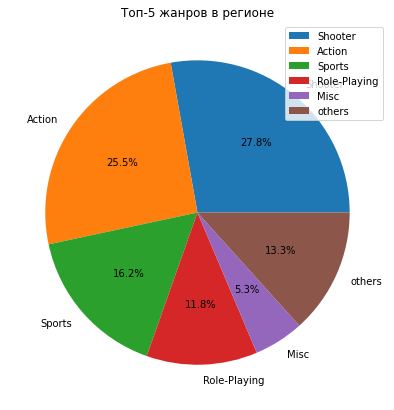

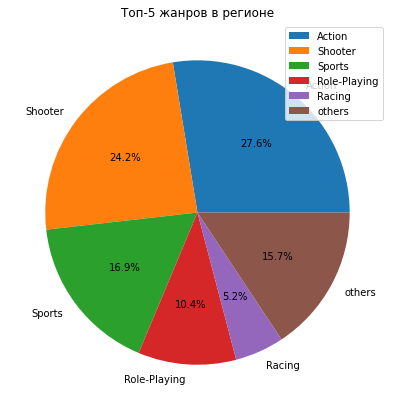

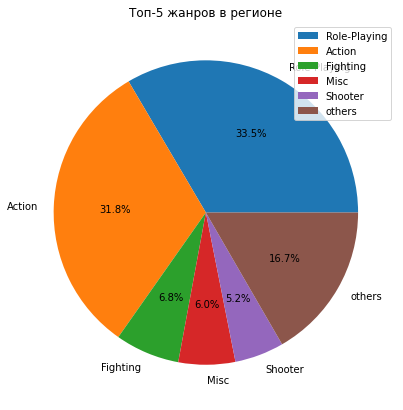

In [43]:
for f in po:
    qwe = df.pivot_table(index='genre', values=f, aggfunc=('sum'))\
.sort_values(by=[f], ascending=False)
    qwe.reset_index(inplace=True)
    out = qwe.iloc[:5]
    out = out.append(
        {"genre": 'others', f: qwe[f].iloc[5:].sum()},
        ignore_index=True,
)
    out.set_index([['a','b','c','d','e','f']])
    out = out.set_index('genre')
    out.plot(kind='pie', y=f, figsize=(12,7), autopct='%1.1f%%');
    plt.title('Топ-5 жанров в регионе');
    plt.ylabel('');

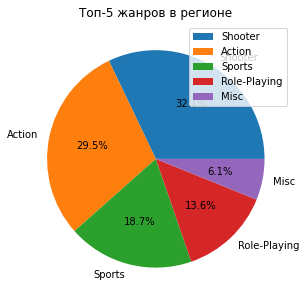

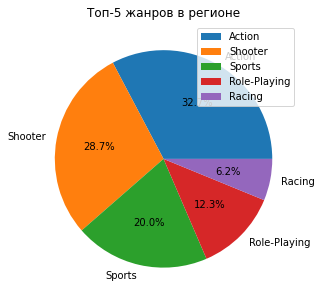

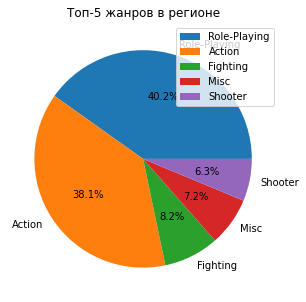

In [44]:
for pie in po:
    df.pivot_table(index='genre', values=pie, aggfunc=('sum'))\
.sort_values(by=[pie], ascending=False)[:5].plot(kind='pie', y=pie, figsize=(7,5), autopct='%1.1f%%');
    plt.title('Топ-5 жанров в регионе');
    plt.ylabel('')
    

**<font color="green">Комментарий студента:<font>** 

**Топ-5 в СА**: Action, Shooter, Sports, Misc, Role-Playing
    
**Топ-5 в Европе**: Action, Shooter, Sports, Role-Playing, Misc
    
**Топ-5 в Японии**: Role-Playing, Action, Misc, Platform, Adventure
    
Здесь можем заметить **схожую** тенденцию между игроками в СА и Европе. Все жанры повторяются лишь с небольшими различиями. Игроки из Японии **сильно** отличаются. Лидером среди жанров являются компьтерные **ролевые** игры, далее знакомый нам жанр **экшен** игр. Далее происходит резкий скачок **вниз**, продаж относительно жанра всё меньше.

#### Распределение продаж по рейтингу в разных регионах

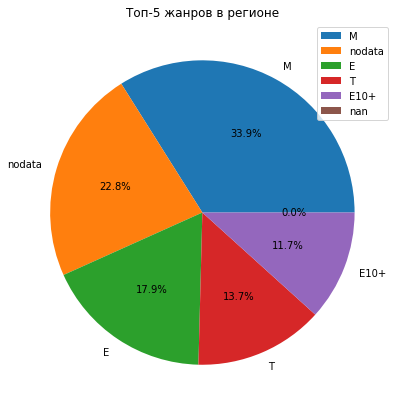

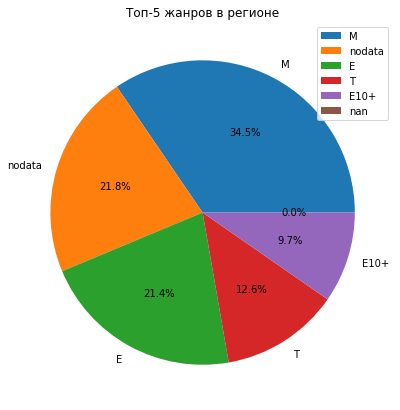

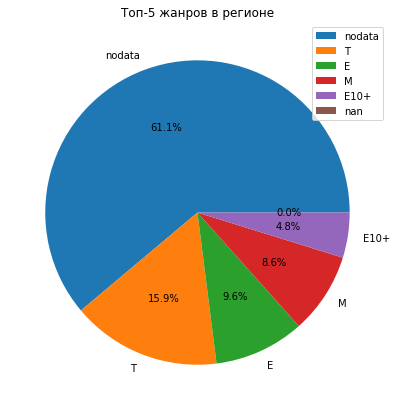

In [45]:
for rating in po:
    qwe = df.pivot_table(index='rating', values=rating, aggfunc=('sum'))\
.sort_values(by=[rating], ascending=False)
    qwe.reset_index(inplace=True)
    out = qwe.iloc[:5]
    out = out.append(
        {"genre": 'others', platform: qwe[rating].iloc[5:].sum()},
        ignore_index=True,
)
    out.set_index([['a','b','c','d','e','f']])
    out = out.set_index('rating')
    out.plot(kind='pie', y=rating, figsize=(12,7), autopct='%1.1f%%');
    plt.title('Топ-5 жанров в регионе');
    plt.ylabel('');

**<font color="green">Промежуточный вывод:<font>** 
    
Игроки из Северной Америки и Европы имеют **похожий** портрет потребителя. **Магазину** при построении бизнес-процессов стоит рассматривать эти два разных рынка **практически** как одно целое, с небольшими отличиями, но ни в коем случае **не создавать** идентичную стратегию. Различия присутствуют.
    
Игроки из СА и Европы любят поиграть в **активные** игры и **спортивные** симуляторы. Предпочитаемые платформы - **PlayStation и Xbox**, но также играют с помощью **ПК**.
    
Игроки из Японии живут в отдельном мире для геймеров, любимый жанр - **Ролевые игры**, любимые платформы - **отечественные!** Однако в Японии **ПК** абсолютно не пользуется спросом.
    
Разница в рейтинге между регионами присутсвует только в случае с Японией.

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Я попытался, но осталось вопросы. 
    
Как объединить остальные жанры/платформы в 'другие'? Скорее всего с помощью where(), но не смог решить задачку.

Общее название для всех 3 графиков.

Графики выводились горизонтально. Помогитееее
    
P.S. Оставил выводы старые, так как в новых графиках не смог отобразить всю информацию.

### Проверка гипотез

####  Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**H0** - Средние пользовательские рейтинги Xbox One равны средним пользовательским рейтингам PC. 

**H1** - Средние пользовательские рейтинги Xbox One не равны средним пользовательским рейтингам PC.

In [46]:
XOne = XOne.dropna(subset=['user_score'])
PC = PC.dropna(subset=['user_score'])

In [47]:
alpha = 0.05
results = st.ttest_ind(XOne['user_score'], PC['user_score'], equal_var=False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-info"> <b>Комментарий студента №2:</b>

Проверим различия средних визуально.

In [48]:
print('Средняя пользовательская оценка для XOne равна:', round(XOne['user_score'].mean(), 2))
print()
print('Средняя пользовательская оценка для ПК равна:', round(PC['user_score'].mean(), 2))

Средняя пользовательская оценка для XOne равна: 6.59

Средняя пользовательская оценка для ПК равна: 6.3


<div class="alert alert-info"> <b>Комментарий студента №2:</b> Исправил альернативную гипотезу.

**<font color="green">Комментарий студента:<font>**  При всех возможных уровнях статистических значимостей - **не получается отвергнуть** нулевую гипотезу. Средние пользовательских оценок достаточно близки между игроками XOne и ПК.

#### Средние пользовательские рейтинги жанров Action и Sports разные.

**H0** - Средние пользовательские рейтинги жанра/ Action равны средним пользовательским рейтингам жанра Sports. 

**H1** - Средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports.

In [49]:
action = df.query('genre == "Action"')
sport = df.query('genre == "Sports"')

In [50]:
action = action.dropna(subset=['user_score'])
sport = sport.dropna(subset=['user_score'])

In [51]:
alpha = 0.05
results = st.ttest_ind(action['user_score'], sport['user_score'], equal_var=False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


In [52]:
print('Средняя пользовательская оценка для экшен игр равна:', round(action['user_score'].mean(), 2))
print()
print('Средняя пользовательская оценка для спортивных симуляторов равна:', round(sport['user_score'].mean(), 2))

Средняя пользовательская оценка для экшен игр равна: 6.76

Средняя пользовательская оценка для спортивных симуляторов равна: 5.23


**<font color="green">Комментарий студента:<font>**  При всех возможных уровнях статистических значимостей - **отвергаем** нулевую гипотезу. Пользовательские оценки для жанра экшен и спортивных симуляторов разные!

<div class="alert alert-info"> <b>Комментарий студента №2:</b> 
    
При составлении гипотез нужно учитывать следующее правило:

**Нулевая** гипотеза всегда декларирует равенство (отсутствие различий), **альтернативная** же - неравенство (наличие различий).    
    
Так как у нас нет значения, с которым нужно сравнить, то в обоих случаях был выбран тест **односторонней гипотезы для средних двух генеральных совокупностей** или же "о равенстве средних двух генеральных совокупностей(в нашем случае выборки)". Уровень статестической значимости - 0.05, но во время проверки гипотез изменялся.
    
Небольшой итог проверки **гипотез.** Средние оценки между ПК и Xbox имеют схожую тенденцию, а вот между жанрами экшен и спорт ничего общего.

### Обновленный общий вывод

В проекте были поставлены цели и задачи. Главной целью является увеличение бизнес-показателей компании.

Датасет - не идеальный, были проработаны моменты, улучшающие датафрейм для анализа. В проекте было использовано множество инструментов, которые были изучены мною в первый спринт. 

Теперь к итогам для заказчика:

1. Средний срок "жизни" платформы - 10 лет;


2. В 2010 году производство игр имеет наивысший показатель, с 2013 года - более 2000 игр в год;


3. Наиболее привлекательные платформы - PS4/XOne;


4. Между оценками пользователей и продажами игр нет взаимосвязи. Между оценками критиков и продажами есть небольшая взаимосвязь.


5. Shooter наиболее привлекательный жанр.


6. Игроки из Северной Америки и Европы имеют похожий портрет потребителя. Игроки из СА и Европы любят поиграть в активные игры и спортивные симуляторы. Предпочитаемые платформы - PlayStation и Xbox, но также играют с помощью ПК.


7. Для игроков из Японии любимый жанр - Ролевые игры, любимые платформы - японского производства. ПК не в почёте.


8. Разница в рейтинге между регионами присутсвует только в случае с Японией.


9. Средние пользовательских оценок достаточно близки между игроками XOne и ПК.


10. Пользовательские оценки для жанра ACtion и Sports - разные!

**Рекомендации:**

На какие игры стоит обратить внимание?

Основной жанр - shooter, но не стоит акцентировать внимание только на нём, ведь «шутер» популярен в СА и Европе, в Японии лидеруют ролевые игры.

Наиболее популярный рейтинг в СА и Европе -  «M», данные из Японии в ограниченном количестве.

Платформа? Одназначно PS4 и XOne!

Что насчёт оценок? Стоит периодически проверять оценки критиков. 